In [1]:
from collections import Counter
from math import log
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.model_selection import train_test_split

#for visualization
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [2]:
def load_data():
    #load the data
    real_raw = open("datasets/real_headlines.txt", "r")
    real_raw = real_raw.readlines()
    fake_raw = open("datasets/fake_headlines.txt", "r")
    fake_raw = fake_raw.readlines()
    
    #add target label
    fake_label = ["fake" for raw in fake_raw]
    real_label = ["real" for raw in real_raw]
    
    #combine fake and real data
    all_raw = fake_raw+real_raw
    all_label = fake_label + real_label
    
    #call tokenizer
    tokenizer = TfidfVectorizer()
    processed_data = tokenizer.fit_transform(all_raw).toarray()
    
    #split into training, validation and test datasets
    X_train_valid, X_test, y_train_valid, y_test = train_test_split(processed_data,all_label,test_size=0.15)
    X_train, X_val, y_train, y_val = train_test_split(X_train_valid,y_train_valid,test_size=15/85)
    
    return X_train, X_val, X_test, y_train, y_val, y_test, tokenizer

In [3]:
def select_model(train,val,y_train,y_val,depth_start=1,depth_count=20, by = 3):
    """
    train : training data; val = validation data; y_train,y_val: training and validation labels
    depth_start: Max_depth starting number/5 ; depth_count : how many depths to try out.
    by : depth incrementer.
    """
    
    results = dict()
    max_accuracy = 0
    
    for depth in range(depth_start,depth_count):
        for criterion in ["gini","entropy"]:
            classifier = DecisionTreeClassifier(max_depth=depth*by,criterion=criterion)
            classifier.fit(train,y_train)
            result = classifier.score(val, y_val)
            results[(criterion,depth*by)] = result
            if result>max_accuracy:
                best_criterion = criterion
                best_depth = depth
                best_classifier = classifier
                max_accuracy = result
            
    
    for key, value in sorted(results.items(), key = lambda x: x[1]):
        print("Criterion: "+key[0]+".\t Max_Depth: "+str(key[1])+".\t Accuracy: "+ str(value))
    

    return best_criterion, best_depth, best_classifier

In [4]:
def entropy(counts):
    all_entropy = 0
    all_count = sum(counts.values())
    for key,value in counts.items():
        px = value/all_count
        logpx = log(px,2)
        all_entropy -= px*logpx
    return all_entropy

def compute_information_gain(features, train, y_train, word):
    counts = Counter(y_train)
    word = features.index(word)
    all_entropy = entropy(counts)
    after_split = 0
    
    exists = Counter()
    dne = Counter()
    
    for i in range(len(train)):
        if train[i][word]>0:
            if y_train[i]=="real": exists["real"]+=1
            else: exists["fake"]+=1
        else:
            if y_train[i]=="real": dne["real"]+=1
            else: dne["fake"]+=1
    
    p_exists = sum(exists.values())/len(y_train)
    p_dne = 1-p_exists
    after_split += p_exists*entropy(exists)
    after_split += p_dne*entropy(dne)
    
    return all_entropy-after_split

Criterion: gini.	 Max_Depth: 45.	 Accuracy: 0.8020408163265306
Criterion: gini.	 Max_Depth: 30.	 Accuracy: 0.8061224489795918
Criterion: gini.	 Max_Depth: 10.	 Accuracy: 0.8122448979591836
Criterion: entropy.	 Max_Depth: 30.	 Accuracy: 0.8122448979591836
Criterion: gini.	 Max_Depth: 40.	 Accuracy: 0.8122448979591836
Criterion: gini.	 Max_Depth: 35.	 Accuracy: 0.8142857142857143
Criterion: entropy.	 Max_Depth: 40.	 Accuracy: 0.8142857142857143
Criterion: gini.	 Max_Depth: 25.	 Accuracy: 0.8163265306122449
Criterion: gini.	 Max_Depth: 15.	 Accuracy: 0.8204081632653061
Criterion: gini.	 Max_Depth: 20.	 Accuracy: 0.8204081632653061
Criterion: entropy.	 Max_Depth: 15.	 Accuracy: 0.8224489795918367
Criterion: entropy.	 Max_Depth: 20.	 Accuracy: 0.8224489795918367
Criterion: entropy.	 Max_Depth: 45.	 Accuracy: 0.8244897959183674
Criterion: gini.	 Max_Depth: 5.	 Accuracy: 0.826530612244898
Criterion: entropy.	 Max_Depth: 25.	 Accuracy: 0.826530612244898
Criterion: entropy.	 Max_Depth: 35.	 Acc

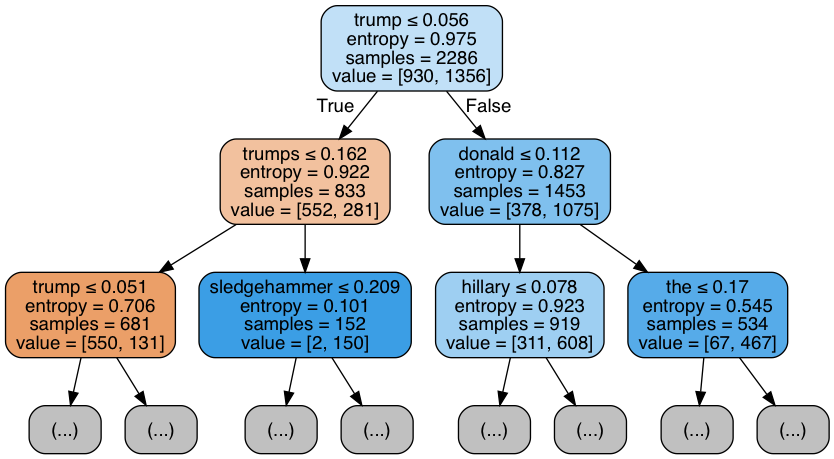

In [5]:
#execution

train, val, test, y_train, y_val, y_test, tokenizer = load_data()
best_criterion, best_depth, best_classifier = select_model(train,val,y_train,y_val,1,10,5)


#Visualization 

vizdata = StringIO()

export_graphviz(best_classifier, out_file=vizdata,  
                filled=True, rounded=True,
                special_characters=True, max_depth=2, feature_names = tokenizer.get_feature_names())

graph = pydotplus.graph_from_dot_data(vizdata.getvalue())  
Image(graph.create_png())

In [6]:
#information gain computation
words = ["the","trumps","hillary","gofundme","trump","what"]

for word in words:
    print("Using " + word +" Info Gain: "+ str(compute_information_gain(tokenizer.get_feature_names(), train,y_train,word)))

Using the Info Gain: 0.05484359155612917
Using trumps Info Gain: 0.044309314589944804
Using hillary Info Gain: 0.034158133368096366
Using gofundme Info Gain: 0.0005677966346253616
Using trump Info Gain: 0.032397129498771604
Using what Info Gain: 0.0004420296982599048
